# Representation Learning

In this part, we'll compare the representations of two different representation learning strategies.
To work on this notebook in Google Colab (if you haven't already set this up), copy the `pset-5` directory to your Google Drive and open this notebook.
This part requires GPUs--start working on a GPU machine with `Runtime -> Change runtime type -> T4 GPU`.

## Submission Guidelines

Your deliverable for this part is `part1/representations.py`.
We will be grading the following three functions: `get_features`, `train_linear_probe` and `find_nearest_neighbors`.

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the
# folder for this part, e.g. '6.8300/pset-5/part1'
FOLDERNAME = "pset-5-main/part1"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/pset-5-main/part1


In [2]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [12]:
# By running this cell, changes to src/representations.py are automatically reflected here.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import numpy as np
import matplotlib.pyplot as plt

### CLIP Representations

The first representation learning method we'll consider is [Constrastive Language-Image Pre-training (CLIP)](https://arxiv.org/pdf/2103.00020).
CLIP consists of an image encoder (typically, a [Vision Transformer](https://arxiv.org/abs/2010.11929)) and a text encoder jointly trained using image-caption pairs.
Specifically, given a batch of images and captions, the CLIP objective seeks to maximize the representation similarity between each image and its associated caption and minimize the similarity between each image and other captions in the batch.

# <img src="https://drive.google.com/uc?export=view&id=1Ci-iULI7vfrbgUCEWaJmcTdTIB7SjgV7" width="80%" style="display: block; margin-left: auto; margin-right: auto;">

Because captioned images are widely available on the internet, we're able to construct datasets of billions of examples for training CLIP representations without any manual labeling.
CLIP representations are used as part of many state-of-the-art vision-language systems.
In this assignment, we'll be working with an existing pre-trained CLIP from [PyTorch Image Models](https://huggingface.co/timm) trained by OpenAI on a dataset of 400 million image-caption pairs.

In [21]:
from representations import create_feature_extractor

feature_extractors = {}

In [22]:
feature_extractors["clip"] = create_feature_extractor("vit_base_patch16_clip_224", "openai")

### DINO Representations

The second representation learning method we'll consider is [DINO](https://arxiv.org/pdf/2104.14294).
This is a self-supervised method that considers different augmentations of an image, and aligns the model's representation of one augmented view with a *teacher model*'s representation of another augmented view.
The teacher model is a moving average of the model itself with centered representations to encourage different representations between different images.

# <img src="https://drive.google.com/uc?export=view&id=17qhCaCu9mEzDBfedu6_LHpnQlqSGSua2" width="80%" style="display: block; margin-left: auto; margin-right: auto;">

The details are somewhat subtle and aren't important for this assignment--if you're interested, you should check out the [paper](https://arxiv.org/pdf/2104.14294)!
The DINO model that we'll be considering is a Vision Transformer trained on [ImageNet](https://en.wikipedia.org/wiki/ImageNet), with the same architecure as the CLIP model.
<!-- This DINO model has a slightly different architecture than the CLIP model that we're considering and its representations have a different dimension, but running it requires a similar amount of compute to the CLIP model. -->
<!-- The second representation learning method we'll consider is supervised learning on [ImageNet-21K](https://en.wikipedia.org/wiki/ImageNet) (a larger and more diverse superset of the widely used ImageNet-1K dataset). -->
<!-- We'll consider the representations of a pre-trained model from [Steiner et al.](https://arxiv.org/abs/2106.10270) which uses the same Vision Transformer architecture as our CLIP model. -->

In [23]:
feature_extractors["dino"] = create_feature_extractor("vit_base_patch16_224", "dino")

## Part 1.1: Evaluating representation quality with linear probes
A common method for evaluating the quality of representations is to measure downstream task performance when using these representations.
Specifically, for classification tasks, we might train a *linear probe* on top of given representations (i.e., a linear classification head) using a labeled dataset.
If the representations contain high-quality features for the classification task, then a linear probe should be sufficient to attain good performance.

We'll consider a classification dataset of photos of fruit consisting of ten classes from ImageNet.
Run the following cell to download the dataset and visualize a sample from each class.

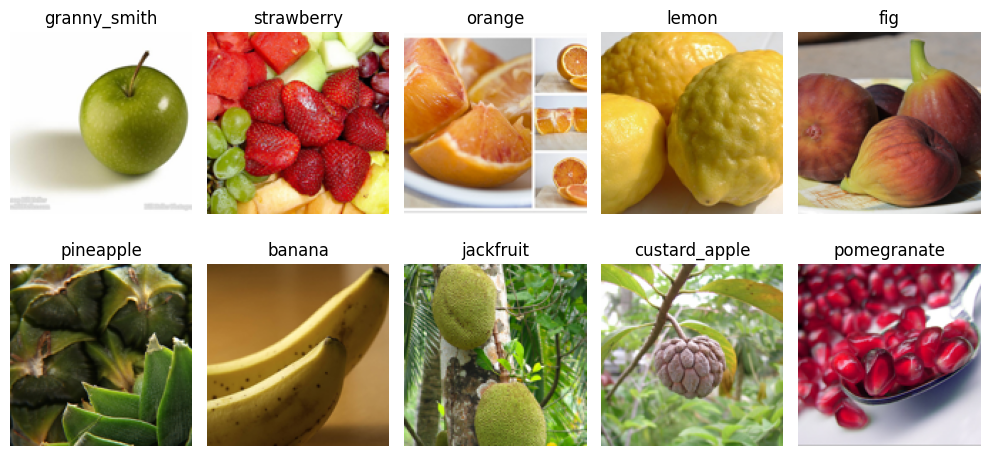

In [24]:
from representations import visualize_samples

visualize_samples("photo_val", seed=0)

Now it's time to train a linear probe! This will consist of two steps:

1. Extract representations by running a feature extractor over a dataset.
1. Train a linear classifier to predict labels from these representations.

In `part1/representations.py` fill in the code for `get_features` and `train_linear_probe`.

In [29]:
from representations import train_linear_probe, FeaturesDataset

linear_probes = {}

We'll first extract features (we'll do this once at the beginning so that training the linear probe over multiple epochs is cheap).
Here, `FeaturesDataset.create` invokes `get_features` (that you've implemented in `part1/representations.py`) to create a dataset of image representations and their corresponding labels.
It should take about two minutes to extract features for each model (if this is taking longer, you may be computing gradients rather than just extracting features).

In [30]:
train_features_datasets = {}
for method_name, feature_extractor in feature_extractors.items():
    train_features_datasets[method_name] = FeaturesDataset.create("photo_train", feature_extractor)

hello


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Computed features shape: (13000, 768)
hello
Computed features shape: (13000, 768)


In [31]:
# If you've implemented get_features_and_labels correctly, these assertions should pass
for method_name in feature_extractors:
    assert train_features_datasets[method_name].features.shape == (13000, 768)
assert np.allclose(train_features_datasets["clip"].features[0, :4], [0.11404128, -1.6733027, 0.5394742, 0.63303655], rtol=0, atol=0.01)
assert np.allclose(train_features_datasets["dino"].features[0, :4], [2.699501, 1.6249989, 3.165336, 1.0346793], rtol=0, atol=0.01)

Next, we'll train a linear probe on top of CLIP representations. If your implementation is correct, your training loss on the final epoch should be roughly 0.2.

In [32]:
def plot_losses(losses, name):
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training loss for {name}")
    plt.show()

Epoch 1/32, Loss: 1.2545
Epoch 2/32, Loss: 0.4686
Epoch 3/32, Loss: 0.3624
Epoch 4/32, Loss: 0.3221
Epoch 5/32, Loss: 0.2981
Epoch 6/32, Loss: 0.2813
Epoch 7/32, Loss: 0.2693
Epoch 8/32, Loss: 0.2591
Epoch 9/32, Loss: 0.2508
Epoch 10/32, Loss: 0.2453
Epoch 11/32, Loss: 0.2405
Epoch 12/32, Loss: 0.2340
Epoch 13/32, Loss: 0.2305
Epoch 14/32, Loss: 0.2266
Epoch 15/32, Loss: 0.2240
Epoch 16/32, Loss: 0.2220
Epoch 17/32, Loss: 0.2189
Epoch 18/32, Loss: 0.2162
Epoch 19/32, Loss: 0.2144
Epoch 20/32, Loss: 0.2131
Epoch 21/32, Loss: 0.2112
Epoch 22/32, Loss: 0.2105
Epoch 23/32, Loss: 0.2085
Epoch 24/32, Loss: 0.2074
Epoch 25/32, Loss: 0.2072
Epoch 26/32, Loss: 0.2067
Epoch 27/32, Loss: 0.2060
Epoch 28/32, Loss: 0.2053
Epoch 29/32, Loss: 0.2035
Epoch 30/32, Loss: 0.2022
Epoch 31/32, Loss: 0.2016
Epoch 32/32, Loss: 0.2015


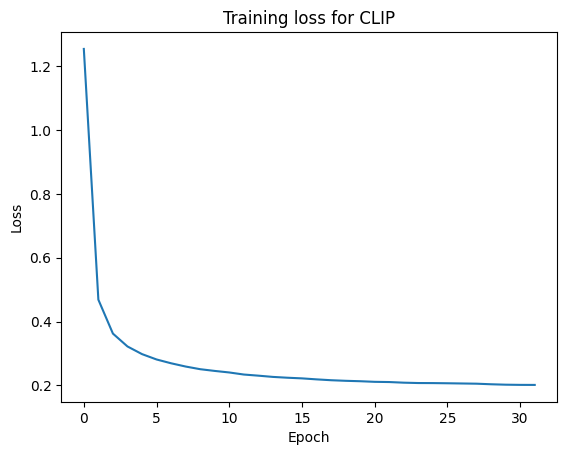

In [33]:
linear_probes["clip"], losses = train_linear_probe(train_features_datasets["clip"])
plot_losses(losses, "CLIP")


Finally, we'll train a linear probe on top of DINO representations. If your implementation is correct, your training loss on the final epoch should be roughly 0.1.

Epoch 1/32, Loss: 0.8114
Epoch 2/32, Loss: 0.3099
Epoch 3/32, Loss: 0.2600
Epoch 4/32, Loss: 0.2314
Epoch 5/32, Loss: 0.2137
Epoch 6/32, Loss: 0.1987
Epoch 7/32, Loss: 0.1876
Epoch 8/32, Loss: 0.1768
Epoch 9/32, Loss: 0.1700
Epoch 10/32, Loss: 0.1638
Epoch 11/32, Loss: 0.1567
Epoch 12/32, Loss: 0.1499
Epoch 13/32, Loss: 0.1465
Epoch 14/32, Loss: 0.1427
Epoch 15/32, Loss: 0.1374
Epoch 16/32, Loss: 0.1339
Epoch 17/32, Loss: 0.1310
Epoch 18/32, Loss: 0.1268
Epoch 19/32, Loss: 0.1251
Epoch 20/32, Loss: 0.1226
Epoch 21/32, Loss: 0.1217
Epoch 22/32, Loss: 0.1186
Epoch 23/32, Loss: 0.1167
Epoch 24/32, Loss: 0.1143
Epoch 25/32, Loss: 0.1125
Epoch 26/32, Loss: 0.1119
Epoch 27/32, Loss: 0.1107
Epoch 28/32, Loss: 0.1093
Epoch 29/32, Loss: 0.1083
Epoch 30/32, Loss: 0.1077
Epoch 31/32, Loss: 0.1082
Epoch 32/32, Loss: 0.1050


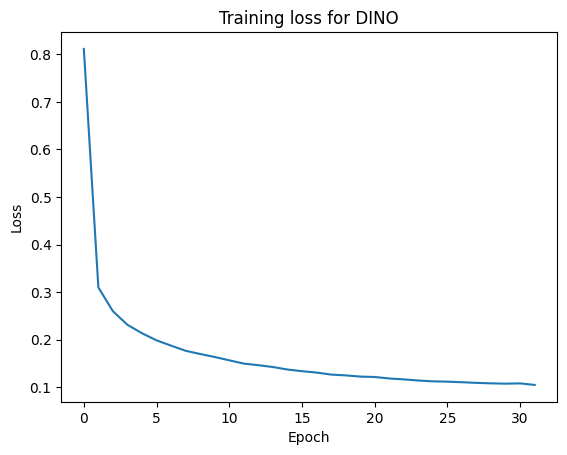

In [34]:
linear_probes["dino"], losses = train_linear_probe(train_features_datasets["dino"])
plot_losses(losses, "DINO")

We'll now evaluate the linear probes on the validation split of our fruit dataset.
If your implementation is correct, both CLIP and DINO representations should yield a validation accuracy of about 90%.

In [35]:
from representations import evaluate_linear_probe


for method_name, linear_probe in linear_probes.items():
    photo_val_features_dataset = FeaturesDataset.create("photo_val", feature_extractors[method_name])
    accuracy = evaluate_linear_probe(photo_val_features_dataset, linear_probe)
    print(f"{method_name} validation accuracy: {accuracy:.4f}")

hello
Computed features shape: (500, 768)
clip validation accuracy: 0.9240
hello
Computed features shape: (500, 768)
dino validation accuracy: 0.8820


## Part 2.2 Understanding the generalization of representations

In the previous part, we found that we can effectively use both CLIP and DINO representations for classification in our fruit setting.
In this part, we'll investigate their quality further.
Are therse representations indeed equally effective? Are there any differences in the behaviors of these representations?

While CLIP and DINO are different algorithms for learning representations, we'll be focusing on another critical difference between these feature extractors: their *training data*.
Recall that the CLIP model was trained using image-caption pairs collected from the internet.
This results in quite a diverse data distribution--for example, if we search for "French Cat" within this dataset we'll find a wide array of images including photos and drawings.
The following are such images from [LAION-5B](https://arxiv.org/pdf/2210.08402), an open dataset similar to that used by OpenAI to train the CLIP model we're working with.

# <img src="https://drive.google.com/uc?export=view&id=1AjDjxfoMv4UJBWWlsS7SwljgaZpTxk8j" width="80%" style="display: block; margin-left: auto; margin-right: auto;">

Meanwhile, DINO was trained on ImageNet, which specifically consists of photos of its 1,000 classes.
Examples from ImageNet might look like the following (it is relatively less stylistically diverse).

# <img src="https://drive.google.com/uc?export=view&id=1TX2R3Klg8aCt9e1Mpd-tkyccLUuzbsbC" width="80%" style="display: block; margin-left: auto; margin-right: auto;">

Given the diversity of CLIP's training data, we might expect its representations to be more effective on a larger diversity of data.
To test this, we'll consider a dataset of sketches of fruit derived from [ImageNet Sketch](https://github.com/HaohanWang/ImageNet-Sketch) with the same classes as our original fruit dataset.
Let's start by visualizing a sample from each class.

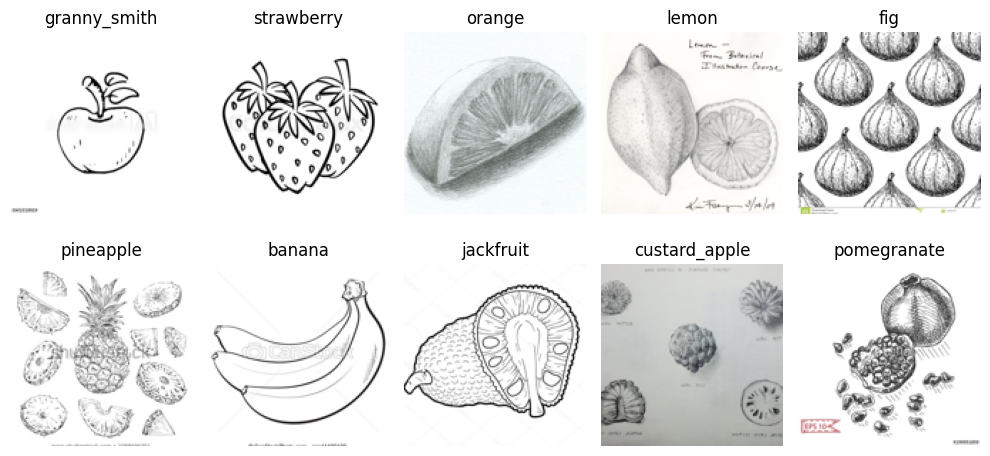

In [36]:
visualize_samples("sketch_val", seed=0)

Here, it seems like representations trained just on photos might not be enough.
Let's evaluate the linear probes that we trained earlier on this sketch dataset.

In [37]:
for method_name, linear_probe in linear_probes.items():
    photo_val_features_dataset = FeaturesDataset.create("sketch_val", feature_extractors[method_name])
    accuracy = evaluate_linear_probe(photo_val_features_dataset, linear_probe)
    print(f"{method_name} validation accuracy: {accuracy:.4f}")

hello
Computed features shape: (508, 768)
clip validation accuracy: 0.6417
hello
Computed features shape: (508, 768)
dino validation accuracy: 0.3898


This time, you should see a large performance gap of about 20%!
So if we care about representations that can be used robustly across domains, CLIP representations are much better.
To investigate this further, for a few different examples of photos of fruit, let's visualize the nearest sketches of fruit.
For effective representations, the nearest neighbors of a photo of a given fruit (among the sketches of fruit) should be sketches of the same fruit.
We'll start by computing CLIP and DINO representations for the validation photos and sketches of fruit.

In [38]:
from representations import get_features

photo_features = {}
sketch_features = {}
for method_name, feature_extractor in feature_extractors.items():
    photo_features[method_name], _, _ = get_features("photo_val", feature_extractor)
    sketch_features[method_name], _, _ = get_features("sketch_val", feature_extractor)

hello
Computed features shape: (500, 768)
hello
Computed features shape: (508, 768)
hello
Computed features shape: (500, 768)
hello
Computed features shape: (508, 768)


To find the nearest neighbors, implement the function `find_nearest_neighbors` in `part1/representations.py`.
If your implementation is correct, your nearest neighbors and similarities for `query_index = 153` should be a `lemon` with similarity `0.713` for CLIP and a `granny_smith` with similarity `0.450` for DINO (see the reference output below).

In [45]:
from representations import visualize_nearest_neighbors

Nearest neighbors for CLIP


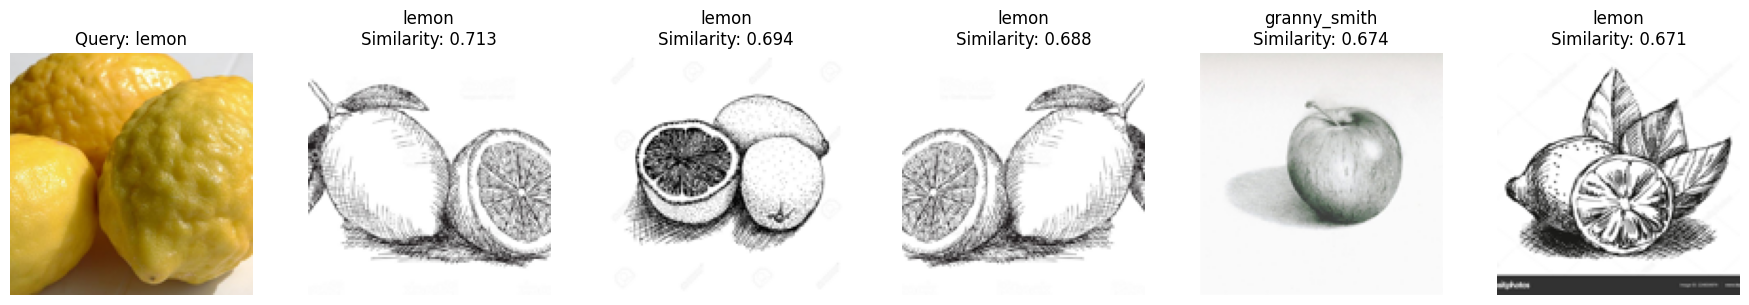

Nearest neighbors for DINO


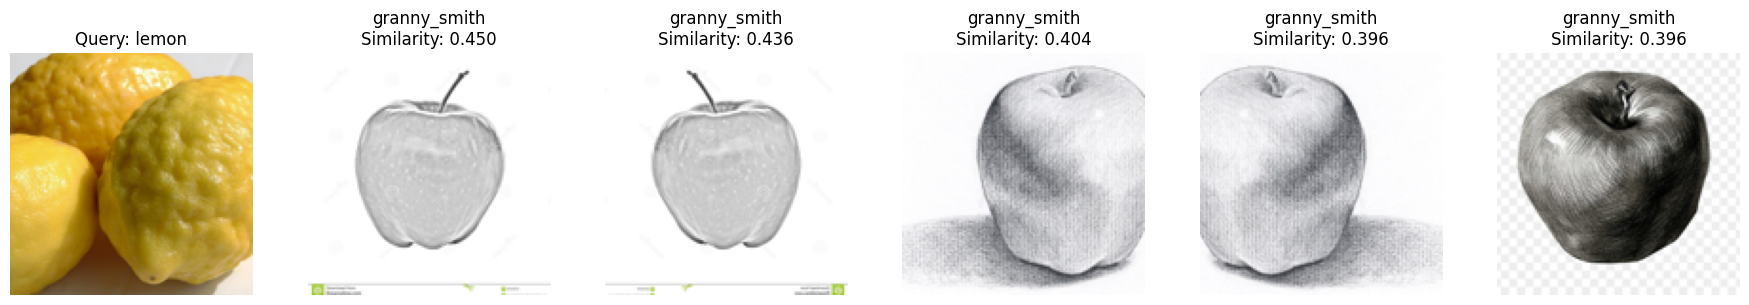

In [46]:
query_index = 153
# Uncomment this to compare the nearest neighbors for different examples
# query_index = np.random.randint(0, len(photo_features[method_name]))

print("Nearest neighbors for CLIP")
visualize_nearest_neighbors(photo_features, sketch_features, "clip", query_index)

print("Nearest neighbors for DINO")
visualize_nearest_neighbors(photo_features, sketch_features, "dino", query_index)